This notebook describes how to compute and derive insights from various classification evaluation metrics.

- **Model evaluation** is an important part of a training process since it ensures that a model has been properly trained on the existing dataset and can be used to make predictions for an unseen dataset.

- There are a number of metrics such as accuracy, precision, recall, f1-score that are commonly used to evaluate a model. They are calculated based on the number of correct and incorrect predictions broken down by each class.  



The dataset used in this notebook was downloaded from https://archive.ics.uci.edu/ml/index.php. The dataset contains four numerical predictors, and the target is a binary variable that indicates whether or not a person donated blood (1 and 0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### read data & eda

In [2]:
df=pd.read_csv('metrics_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Donated    748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [5]:
df['Donated'].value_counts()

0    570
1    178
Name: Donated, dtype: int64

In [6]:
print ('# duplicates label 0:', len(df[(df['Donated']==0) & (df.duplicated())]))
print('# duplicates label 1:',len(df[(df['Donated']==1) & (df.duplicated())]))

# duplicates label 0: 186
# duplicates label 1: 29


In [7]:
# drop duplicates
df= df.drop_duplicates()

In [8]:
# slightly imbalanced dataset
print('% of label 1 samples: {:.2%}'.format(len(df[df['Donated']==1])/len(df)))
print('% of label 0 samples: {:.2%}'.format(len(df[df['Donated']==0])/len(df)))

% of label 1 samples: 27.95%
% of label 0 samples: 72.05%


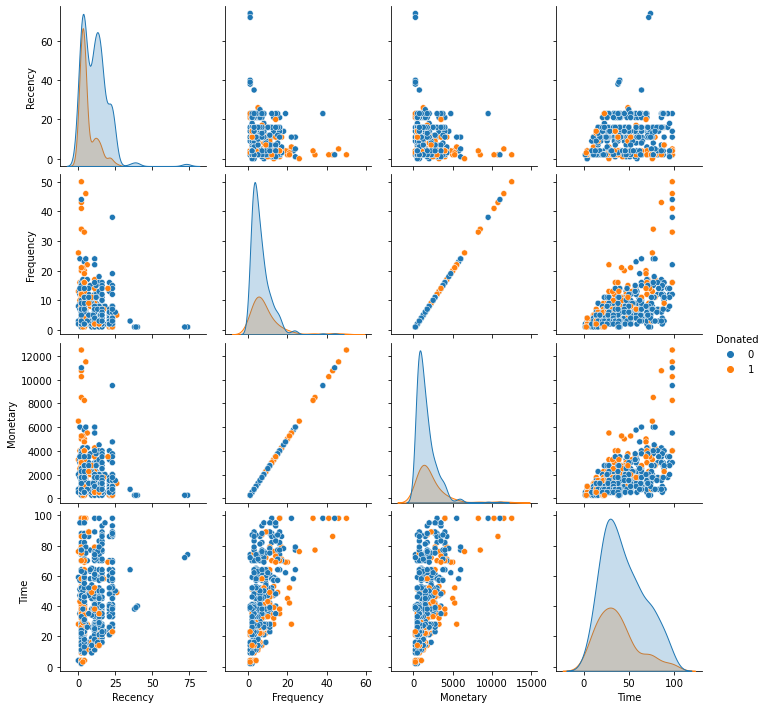

In [9]:
sns.pairplot(df, hue='Donated', diag_kind='kde')

In [10]:
# suspicious correlation. Monetary equals blood donated each time (cc) * Frequency .
(df['Monetary']/df['Frequency']).unique()

array([250.])

In [11]:
# repeated variable must be removed
df=df.drop('Monetary', axis=1)

In [12]:
print('Number of outlier Recency values: ',(df['Recency']>30).sum())

Number of outlier Recency values:  6


In [13]:
# removes rows with outlier recency data
df= df[df['Recency']<30]

In [14]:
# generates new feature, normalizes frequency by number of months since the first donation 
df['Freq_month']=df['Frequency']/df['Time']

In [15]:
df.head()
# print()

,Recency,Frequency,Time,Donated,Freq_month
0,2,50,98,1,0.510204
1,0,13,28,1,0.464286
2,1,16,35,1,0.457143
3,2,20,45,1,0.444444
4,1,24,77,0,0.311688


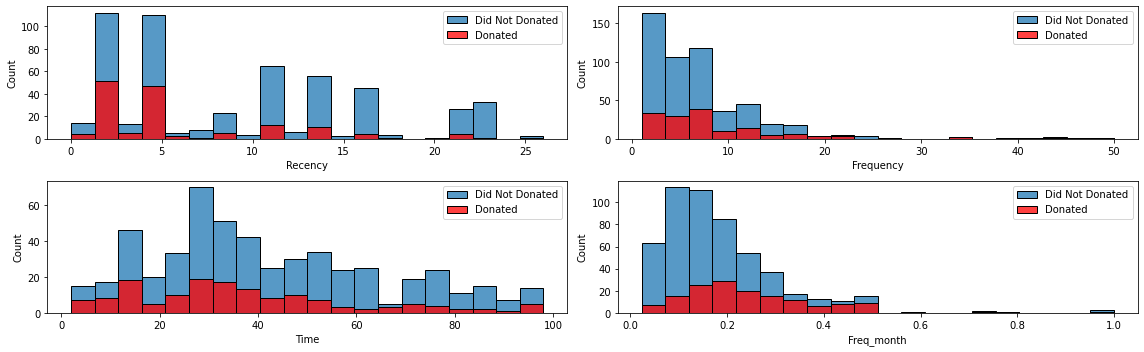

In [16]:
fig, axes= plt.subplots(2,2, figsize=(16,5))
axes=axes.flatten()

for i, col in enumerate (df.drop('Donated', axis=1)):
    sns.histplot(df.loc[:,col], ax=axes[i], bins=20, binrange=[min(df[col]),max(df[col])], label='Did Not Donated')
    sns.histplot(df.loc[df['Donated']==1,col], ax=axes[i], color='red', bins=20, 
                 binrange=[min(df[col]),max(df[col])], label='Donated')
    axes[i].legend()
plt.tight_layout()
# print()

- Those who recently donated (low Recency), most likely donate again
- Those with larger Recency are less likely to donate (change in physical/health condition, age, or forgetting)
- Among those with higher donation per month (more active donors), the possibility of donation is higher
- Frequency is less than 10 times for most people which means people are not willing to donate more than 10 times

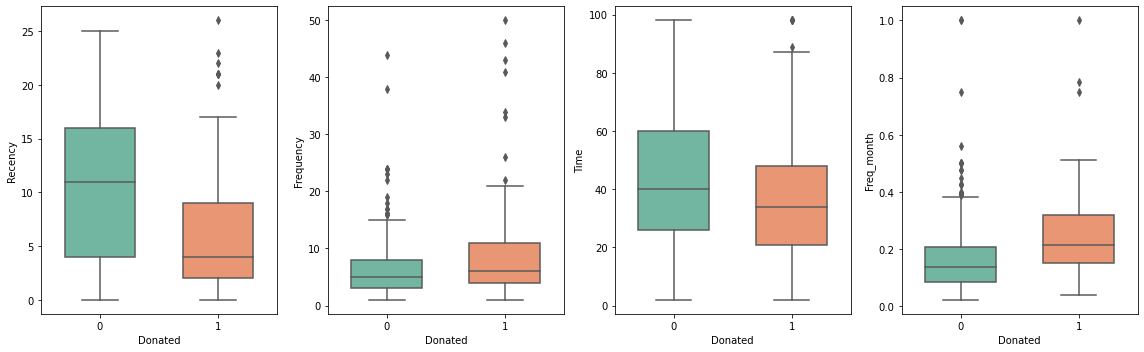

In [17]:
fig, axes= plt.subplots(1,4, figsize=(16,5))

for i, col in enumerate(df.drop('Donated', axis=1)):
    sns.boxplot(x='Donated',y=col, data=df, palette="Set2", order=[0, 1], ax=axes[i], width=0.6)
plt.tight_layout()
# print()

- Recency and Freq_month are two variables with slightly different median and range of values for two classes 

### Classification
A SVM classifier was used to predict whether or not a person would donate blood. Please note that default parameters were used without tuning any hyper-parameters in order to stay focused on the metrics topic.

In [18]:
# creates predictors and target datasets
X= df.drop('Donated', axis=1)
y=df['Donated']

In [19]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [58]:
# split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, stratify=y, random_state=107)

In [59]:
# scale the predictor features based on the training data 
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [60]:
# fits the model- KNN was used as it is less impacted by imbalnce in the data compared to other classifiers
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

- There are a number of metrics such as accuracy, precision, recall, f1-score that are commonly used to evaluate a model. They are calculated based on the number of correct and incorrect predictions broken down by each class that are usually represented by a confusion matrix.  

### 1) Confusion matrix
- A confusion matrixthe represents the number of correct and incorrect predictions broken down by each class.

In [34]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, knn.predict(X_test))

array([[95, 19],
       [31, 14]], dtype=int64)

**Note**: Values extracted from the confusion matrix: TP=14, FP=19, TN=95, FN=31
- The number of class 0 samples is greater than the number of class 1 samples, resulting in an imbalance. In a separate notebook, I discussed dealing with imbalanced datasets, and you can find out about techniques that are used for creating a balanced dataset.
 

In this case, I attempted to create a training dataset with an equal number of samples for each class using an oversampling method.

In [24]:
from imblearn.combine import SMOTETomek

In [61]:
# oversampling the data
smt = SMOTETomek(sampling_strategy='auto', random_state=105)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [62]:
# fit the model to new datasets
svc=SVC(probability=True)

svc.fit(X_train_smt, y_train_smt)

SVC(probability=True)

In [63]:
confusion_matrix(y_test, svc.predict(X_test))

array([[77, 18],
       [15, 22]], dtype=int64)

**Insight:** Using a balanced dataset to train the model improved model performance for class 1.


### 2) Accuracy
- Although a confusion matrix can provide useful information, looking at and digesting all of the numbers presented in the matrix can sometimes be overwhelming. Confusion matrices can be summarized into a single value metric such as accuracy, recall, or precision.

- Accuracy is defined as the ratio of the number of correctly classified samples to the total number of samples. For a training task, a model accuracy is represented by a single value (unlike other parameters such as precision, recall, and f1-score that are reported for each class using 1 vs. all methodology).

$$Accuracy=TP/(TP+FP+TN+FN)$$

In [64]:
from sklearn.metrics import accuracy_score

print ('Accuracy (imbalanced dataset): {:2.2%}'.format(accuracy_score(y_test, knn.predict(X_test))))
print ('Accuracy (balanced dataset): {:2.2%}'.format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy (imbalanced dataset): 67.42%
Accuracy (balanced dataset): 75.00%


- Accuracy may become a misleading and ineffective metric in the case of an imbalanced dataset in which the number of samples belonging to one class is significantly greater than the others.

- The first model that was trained on the imbalanced dataset performed poorly on class 1; however, the model accuracy is higher due to the large number of true negative samples.

### 3) Recall
- Recall is the proprtion of samples in a class that are correctly predicted.

- If the target class is important in your analysis and you do not want any of the target samples to be classified as non-target class, recall is the metric to focus on as a high recall rate relates to a low false negative rate.
$$Recall=TP/(TP+FN)$$

In [65]:
from sklearn.metrics import recall_score

print ('Recall: {:2.2%}'.format(recall_score(y_test, svc.predict(X_test))))

Recall: 59.46%


**insight:** A high recall value shows that the model correctly predicted the majority of those who donated blood. 

###  4) Precision
- Precision is defined by the ratio of predicted positive samples being actually positive. 

- If you don't want a large number of non-target class samples to be classified as target class, precision could be the primary metric for your analysis as high precision relates to a low false positive rate.
$$Precision=TP/(TP+FP)$$

In [45]:
from sklearn.metrics import precision_score

In [66]:
print ('Precision: {:2.2%}'.format(precision_score(y_test, svc.predict(X_test))))

Precision: 55.00%


**Insight:** A low precision value indicates that many samples from class 0 (those who did not donate) are classified as class 1.

### 5) f1 score
- Precision and recall can be combined and represented as the f1-score, which is the harmonic average of their values. Both false positive and false negative values are considered to calculate this metric.

In [48]:
from sklearn.metrics import f1_score

In [67]:
print ('f1_score: {:2.2}'.format(f1_score(y_test, svc.predict(X_test))))

f1_score: 0.57


### 6) Precision-recall curve
- There is a trade-off between precision and recall, which means that altering the probability threshold (used to determine the predicted class) increases one parameter while decreasing the other.

- The **precision-recall curve** depicts the trade-off between precision and recall. A large area under the curve indicates that the model has a high recall as well as a high precision.

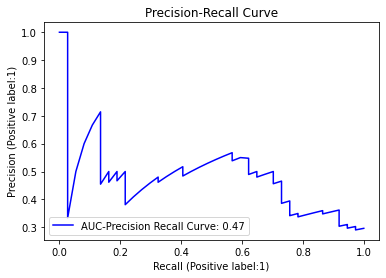

In [68]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, svc.predict_proba(X_test)[:,1])

auc_rp = auc(recall, precision)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue', label="AUC-Precision Recall Curve: {:.2}".format(auc_rp))

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision (Positive label:1)')
ax.set_xlabel('Recall (Positive label:1)')
plt.legend(loc="lower left")
plt.show()

**Insight:** The precision-recall curve shows how quickly precision drops with the slight increase in recall value. As the probality threshold is reduced to allow more samples from class 1 to be predicted as class 1, a large number of samples of class 0 that are also predicted as class 1 (False positive). 
The low auc value, as well as the shape of the graph indicate that the trained model is underfitted (bias issue) and must be re-built.  

### 7) AUC-ROC score
- The AUC-ROC score, which is calculated using the area under the Receiver Operating Characteristics curve, is one of the most reliable metrics for evaluating a classifier.


- The ROC curve is a graphical representation of a classifier's ability to distinguish between classes at different probability thresholds.


- True Positive rate (which is equivalent to recall: TP/TP+FN) is plotted against False Positive rate (FP/FP+TN) at different probability thresholds to generate a ROC graph.


- The ideal case is for the TP rate to remain high while the FP rate decreases as the threshold rises, resulting in a high AUC value. Using the one vs aLL methodology, we can plot the n number of AUC ROC Curves for n number of classes in a multi-class model.

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

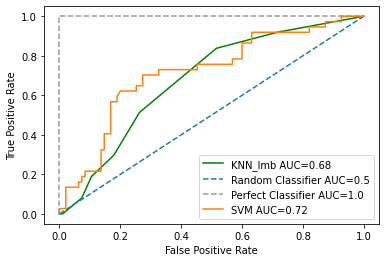

In [69]:
# fpr: false positive rate, tpr=true positive rate
auc_svc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

fpr_svc, tpr_svc, _ = roc_curve(y_test,  svc.predict_proba(X_test)[:,1])

# random classifier. A classifier with no skill. Only predicts 0 for all samples
random_probs = [0 for _ in range(len(y_test))]
auc_random = roc_auc_score(y_test, random_probs)
fpr_rn, tpr_rn, _ = roc_curve(y_test, random_probs)

# classifier trained on imbalanced dataset
auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

fpr_knn, tpr_knn, _ = roc_curve(y_test,  knn.predict_proba(X_test)[:,1])

# perfect classifier. predicting all samples correctly
auc_perfect = roc_auc_score(y_test, y_test)
fpr_pr, tpr_pr, _ = roc_curve(y_test, y_test)


#create ROC curve
plt.plot(fpr_knn,tpr_knn,label="KNN_Imb AUC={:.2}".format(auc_knn), color='green')
plt.plot(fpr_rn, tpr_rn, linestyle='--', label='Random Classifier AUC={:.2}'.format(auc_random))
plt.plot(fpr_pr, tpr_pr, linestyle='--',color='black', alpha=0.4, label='Perfect Classifier AUC={:.2}'.format(auc_perfect))
plt.plot(fpr_svc,tpr_svc,label="SVM AUC={:.2}".format(auc_svc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

- This plot can be used to compare the performance of a model to distinguish a class, the performance of different classifiers (to choose the best performer), or to track the performance of a classifier over time to ensure its performance has not deteriorated and to determine if retraining or remodelling is required. 
- It can also be used to select a suitable threshold value (rather than the default 0.5) in order to achieve the desired TP and FP values.

**Insight:** 
- The auc value for the model is relatively high, but it is far from a well-trained model.

- The graphs for two models (trained with balanced and imbalanced datasets) are similar in shape with slightly higher auc value for SVC, indicating that creating a balanced dataset slightly improved the model performance. However, it still suffers from underfitting. Creating new features from existing predictors or gathering new information may aid in improving model performance.

In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Predictions
y_pred = knn.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Specificity
specificity = TN / (TN + FP)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# True Positive Rate (TPR)
tpr = sensitivity

# False Positive Rate (FPR)
fpr = FP / (FP + TN)

print("Sensitivity (Recall): {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("True Positive Rate (TPR): {:.4f}".format(tpr))
print("False Positive Rate (FPR): {:.4f}".format(fpr))


NameError: name 'knn' is not defined